In [1]:
import sys
sys.path.insert(0, '../')

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt

import torch
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import shap

# Demo

In [4]:
class BinaryData(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X=X
        self.y=y
        self.transform=transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample=self.X[index,:]
        
        if self.transform is not None:
            sample=self.transform(sample)
        
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [5]:
batch_size=64

a_train=torch.empty(1000,1).uniform_(0,1)
x_train=torch.bernoulli(a_train)
x_train=torch.cat([x_train,x_train],axis=1)

y_train=x_train[:,0]

train_dataset=BinaryData(x_train, y_train)
train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
#a_test=torch.empty(1000,2).uniform_(0,1)
#x_test=torch.bernoulli(a_test)
#y_test=x_test[:,0]

#test_dataset=BinaryData(x_test, y_test)
#test_loader=DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

In [7]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(2,1),
                                      torch.nn.Sigmoid())
    def forward(self,x):
        x=self.layers(x)
        return x

In [8]:
def calculate_dependence(model):
    zero_arange=torch.tensor(np.concatenate([np.zeros(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)
    one_arange=torch.tensor(np.concatenate([np.ones(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)


    arange_zero=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.zeros(100).reshape(-1,1)],axis=1)).float().to(device)
    arange_one=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.ones(100).reshape(-1,1)],axis=1)).float().to(device)

    dep1=(model(one_arange)-model(zero_arange)).mean().detach().cpu().numpy().reshape(-1)[0]
    dep2=(model(arange_one)-model(arange_zero)).mean().detach().cpu().numpy().reshape(-1)[0]
    
    return dep2/dep1, dep1, dep2

In [11]:
device=torch.device('cuda')

convergence_list1_list_eg=[]
convergence_list2_list_eg=[]
convergence_list3_list_eg=[]

for k in [1,2,3,4,5]:

    print('k =',k)
    
    model=MLP().to(device)
    
    with torch.no_grad():
        model.layers[0].weight[0,0]=10
        model.layers[0].weight[0,1]=10
        model.layers[0].bias[0]=-6
        
    x_zeros = torch.ones_like(x_train[:,:])
    background_dataset = BinaryData(x_zeros)

    explainer = AttributionPriorExplainer(background_dataset, 64, k=k)        
        

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    bce_term = torch.nn.BCELoss()
    
    train_loss_list_mean_list=[]
    
    convergence_list1=[]
    convergence_list2=[]
    convergence_list3=[]
        
    for epoch in range(200):
        
        train_loss_list=[]
        
        for i, (x, y_true) in enumerate(train_loader):
            x, y_true= x.float().to(device), y_true.float().to(device)
            optimizer.zero_grad()
            
            y_pred=model(x)
            
            eg=explainer.attribution(model, x)
            eg_abs_mean=eg.abs().mean(0)
            
            loss=bce_term(y_pred, y_true.unsqueeze(1)) + eg_abs_mean[1]
            
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss_list.append(loss.item())
            
        train_loss_list_mean=np.mean(train_loss_list)
        
        train_loss_list_mean_list.append(train_loss_list_mean)
        convergence_list1.append(calculate_dependence(model)[0])
        convergence_list2.append(calculate_dependence(model)[1])
        convergence_list3.append(calculate_dependence(model)[2])
        
    convergence_list1_list_eg.append(convergence_list1)
    convergence_list2_list_eg.append(convergence_list2)
    convergence_list3_list_eg.append(convergence_list3)

k = 1
k = 2
k = 3
k = 4
k = 5


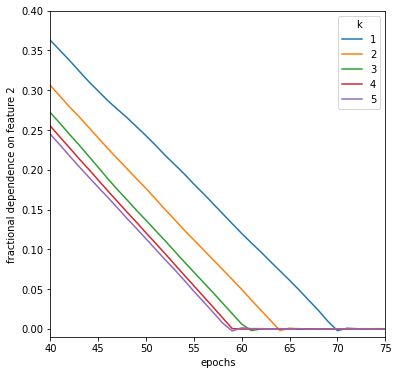

In [14]:
plt.figure(figsize=(6,6))

for k, convergence_list1 in enumerate(convergence_list1_list_eg):
    plt.plot((np.arange(len(convergence_list1))+1), convergence_list1,label=k+1)
    
plt.xlim([40,75])
plt.ylim([-0.01,0.4])
plt.legend(title='k')

plt.xlabel('epochs')
plt.ylabel('fractional dependence on feature 2')
plt.show()

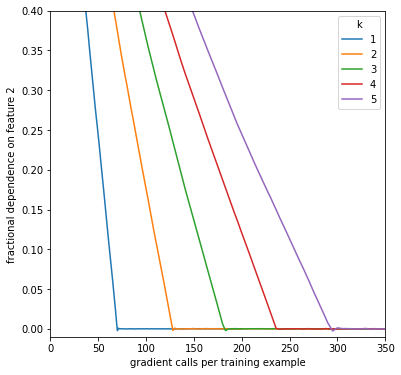

In [15]:
plt.figure(figsize=(6,6))

for k, convergence_list1 in enumerate(convergence_list1_list_eg):
    plt.plot((np.arange(len(convergence_list1))+1)*(k+1), convergence_list1,label=k+1)
    
plt.xlim([0,350])
plt.ylim([-0.01,0.4])
plt.legend(title='k')

plt.xlabel('gradient calls per training example')
plt.ylabel('fractional dependence on feature 2')
plt.show()

# example_usage

In [5]:
feature_mean=0
feature_sigma=1
dummy_sigma=0.5

n_samples=1000
n_features=3

X=np.random.randn(n_samples,n_features)*feature_sigma+feature_mean
X[:,2]=X[:,0]+np.random.randn(n_samples)*dummy_sigma

In [6]:
output_mean=0
output_sigma=0.5
Y=X[:,0]-X[:,1]+np.random.randn(n_samples)*output_sigma+output_mean
Y=Y.reshape([Y.shape[0],1])

In [9]:
data = pd.DataFrame({'Feature 0': X[:, 0], 'Feature 1': X[:, 1], 'Feature 2': X[:, 2], 'Outcome': Y.squeeze()})
alt.Chart(data).mark_point(filled=True).encode(
    x=alt.X(alt.repeat('column'), type='quantitative', scale=alt.Scale(domain=[-4, 4])),
    y=alt.Y('Outcome:Q', scale=alt.Scale(domain=[-6, 6]))
).properties(
    height=200,
    width=200
).repeat(
    column=['Feature 0', 'Feature 1', 'Feature 2']
).properties(
    title='The relationship between the outcome and the three features in our simulated data'
).configure_axis(
    labelFontSize=15,
    labelFontWeight=alt.FontWeight('lighter'),
    titleFontSize=15,
    titleFontWeight=alt.FontWeight('normal')
).configure_title(
    fontSize=18
)

alt.RepeatChart(...)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None):
        self.x=x
        self.y=y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):        
        if self.y is not None:
            return self.x[index], self.y[index]
        else:
            return self.x[index]

In [174]:
batch_size=20

dataset=CustomDataset(x=X,y=Y)
train_dataset, test_dataset, valid_dataset=random_split(dataset, [int(n_samples*0.8), int(n_samples*0.1), int(n_samples*0.1)])

train_dataloader=DataLoader(dataset=train_dataset, batch_size=20, shuffle=True, drop_last=True)
test_dataloader=DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)
valid_dataloader=DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), shuffle=True, drop_last=True)

In [12]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(2,1),
                                      torch.nn.Sigmoid())
    def forward(self,x):
        x=self.layers(x)
        return x

In [13]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(n_features,5),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(5,1))
                                        
    def forward(self, x):
        return self.layers(x)

## train with an attribution prior

In [281]:
device=torch.device('cuda')
model=CustomModel().to(device)


explainer = AttributionPriorExplainer(train_dataset[:][0], batch_size=batch_size, k=1)
explainer_valid = AttributionPriorExplainer(valid_dataset[:][0], batch_size=100, k=1)

optimizer=torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0, dampening=0)

loss_func = torch.nn.MSELoss()

batch_count=0
valid_loss_list=[]
step_list=[]
for epoch in range(15):
    for i, (x, y_true) in enumerate(train_dataloader):
        batch_count+=1

        x, y_true= x.float().to(device), y_true.float().to(device)
        optimizer.zero_grad()

        y_pred=model(x)
        
        eg=explainer.attribution(model, x)
        
        loss=loss_func(y_pred, y_true) + 30*(eg*eg)[:,2].mean()

        loss.backward()
        optimizer.step()
        
        if batch_count%10==0:
            valid_loss=[]
            for i, (x, y_true) in enumerate(valid_dataloader):

                x, y_true= x.float().to(device), y_true.float().to(device)

                y_pred = model(x)
                loss=loss_func(y_pred, y_true)
                valid_loss.append(loss.item())

                eg=explainer_valid.attribution(model,x)

                #print(eg.abs().mean(axis=0).detach().cpu())

            valid_loss_list.append(np.mean(valid_loss))
            step_list.append(batch_count)

                    
test_loss=[]                    
for i, (x, y_true) in enumerate(test_dataloader):

    x, y_true= x.float().to(device), y_true.float().to(device)

    y_pred = model(x)
    loss=loss_func(y_pred, y_true)
    test_loss.append(loss.item())
    
print('MSE:',np.mean(test_loss))

MSE: 0.2743835151195526


In [285]:
data = pd.DataFrame({
    'Iteration': step_list,
    'Validation Loss': valid_loss_list
})
alt.Chart(data
).mark_line().encode(alt.X('Iteration:Q'), alt.Y('Validation Loss:Q', scale=alt.Scale(domain=[0.0, 2.5])))



alt.Chart(...)

### using shap.GradientExplainer

In [283]:
explainer=shap.GradientExplainer(model=model, data=torch.Tensor(X).to(device))
shap_values=explainer.shap_values(torch.Tensor(X).to(device), nsamples=200)

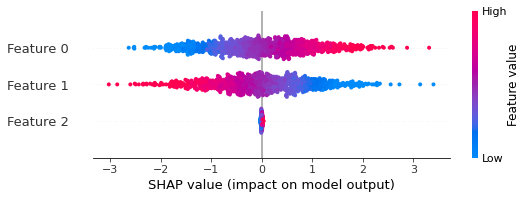

In [286]:
shap.summary_plot(shap_values, X)

### using implemented explainer

In [287]:
explainer_temp = AttributionPriorExplainer(dataset[:][0], batch_size=5, k=200)

temp_dataloader=DataLoader(dataset=dataset, batch_size=5, shuffle=True, drop_last=True)

eg_list=[]
x_list=[]
for i, (x, y_true) in enumerate(temp_dataloader):
    x, y_true= x.float().to(device), y_true.float().to(device)

    eg_temp=explainer_temp.attribution(model, x)
    eg_list.append(eg_temp.detach().cpu().numpy())
    x_list.append(x.detach().cpu().numpy())
eg_list_concat=np.concatenate(eg_list)
x_list_concat=np.concatenate(x_list)    

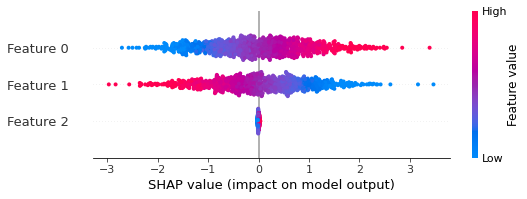

In [289]:
shap.summary_plot(eg_list_concat, x_list_concat)

## train without an attribution prior

In [292]:
device=torch.device('cuda')
model=CustomModel().to(device)


explainer = AttributionPriorExplainer(train_dataset[:][0], batch_size=batch_size, k=1)
explainer_valid = AttributionPriorExplainer(valid_dataset[:][0], batch_size=100, k=1)

optimizer=torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0, dampening=0)

loss_func = torch.nn.MSELoss()

batch_count=0
valid_loss_list=[]
step_list=[]
for epoch in range(15):
    for i, (x, y_true) in enumerate(train_dataloader):
        batch_count+=1

        x, y_true= x.float().to(device), y_true.float().to(device)
        optimizer.zero_grad()

        y_pred=model(x)
        
        eg=explainer.attribution(model, x)
        
        loss=loss_func(y_pred, y_true)# + 30*(eg*eg)[:,2].mean()

        loss.backward()
        optimizer.step()
        
        if batch_count%10==0:
            valid_loss=[]
            for i, (x, y_true) in enumerate(valid_dataloader):

                x, y_true= x.float().to(device), y_true.float().to(device)

                y_pred = model(x)
                loss=loss_func(y_pred, y_true)
                valid_loss.append(loss.item())

                eg=explainer_valid.attribution(model,x)

                #print(eg.abs().mean(axis=0).detach().cpu())

            valid_loss_list.append(np.mean(valid_loss))
            step_list.append(batch_count)

                    
test_loss=[]                    
for i, (x, y_true) in enumerate(test_dataloader):

    x, y_true= x.float().to(device), y_true.float().to(device)

    y_pred = model(x)
    loss=loss_func(y_pred, y_true)
    test_loss.append(loss.item())
    
print('MSE:',np.mean(test_loss))

MSE: 0.28417477011680603


In [293]:
data = pd.DataFrame({
    'Iteration': step_list,
    'Validation Loss': valid_loss_list
})
alt.Chart(data
).mark_line().encode(alt.X('Iteration:Q'), alt.Y('Validation Loss:Q', scale=alt.Scale(domain=[0.0, 2.5])))



alt.Chart(...)

### using shap.GradientExplainer

In [294]:
explainer=shap.GradientExplainer(model=model, data=torch.Tensor(X).to(device))
shap_values=explainer.shap_values(torch.Tensor(X).to(device), nsamples=200)

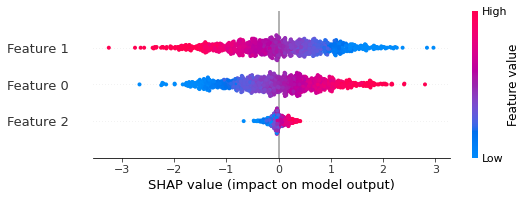

In [295]:
shap.summary_plot(shap_values, X)

### using implemented explainer

In [296]:
explainer_temp = AttributionPriorExplainer(dataset[:][0], batch_size=5, k=200)

temp_dataloader=DataLoader(dataset=dataset, batch_size=5, shuffle=True, drop_last=True)

eg_list=[]
x_list=[]
for i, (x, y_true) in enumerate(temp_dataloader):
    x, y_true= x.float().to(device), y_true.float().to(device)

    eg_temp=explainer_temp.attribution(model, x)
    eg_list.append(eg_temp.detach().cpu().numpy())
    x_list.append(x.detach().cpu().numpy())
eg_list_concat=np.concatenate(eg_list)
x_list_concat=np.concatenate(x_list)    

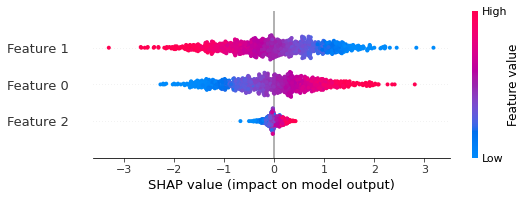

In [297]:
shap.summary_plot(eg_list_concat, x_list_concat)

# MNIST

# AttributionPriorExplainer

In [291]:
"""

https://github.com/suinleelab/attributionpriors/blob/master/attributionpriors/pytorch_ops.py
https://github.com/slundberg/shap/blob/master/shap/explainers/_gradient.py

"""

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

class AttributionPriorExplainer():
    def __init__(self, reference_dataset, batch_size, k):
        self.reference_dataloader=DataLoader(dataset=reference_dataset,
                                             batch_size=batch_size*k,
                                             shuffle=True,
                                             drop_last=True)
        self.reference_dataloader_iterator=iter(self.reference_dataloader)
        
        self.batch_size=batch_size
        self.k=k
        
    def get_reference_data(self):
        try:
            reference_data=next(self.reference_dataloader_iterator)
        except:
            self.reference_dataloader_iterator=iter(self.reference_dataloader)
            reference_data=next(self.reference_dataloader_iterator)
        
        return reference_data
    
    def interpolate_input_reference(self, input_data, reference_data):
        
        alpha=torch.empty(self.batch_size, self.k).uniform_(0,1).to(input_data.device)
        alpha=alpha.view(*([self.batch_size, self.k,]+[1]*len(input_data.shape[1:])))
        
        input_reference_interpolated=(1-alpha)*reference_data+(alpha)*input_data.unsqueeze(1)
        
        return input_reference_interpolated
        
    def diff_input_reference(self, input_data, reference_data):
        return input_data.unsqueeze(1)-reference_data
    
    def get_grad(self, model, input_reference_interpolated):
        input_reference_interpolated.requires_grad=True
        
        input_reference_interpolated_grad=torch.zeros(input_reference_interpolated.shape).float().to(input_reference_interpolated.device)
        for i in range(self.k):
            batch_input=input_reference_interpolated[:,i,]
            batch_output=model(batch_input)
            
            
            grad_out=grad(outputs=batch_output,
                     inputs=batch_input,
                     grad_outputs=torch.ones_like(batch_output).to(input_reference_interpolated.device),
                     create_graph=True)[0]
            input_reference_interpolated_grad[:,i,]=grad_out
        
        return input_reference_interpolated_grad
        
    def attribution(self, model, input_data):
        model_dtype=next(model.parameters()).dtype
        reference_data=self.get_reference_data().to(model_dtype).to(input_data.device)
        
        assert input_data.dtype==model_dtype
        assert input_data.shape[0]==self.batch_size
        assert input_data.shape[1:]==reference_data.shape[1:]
        assert input_data.device==next(model.parameters()).device
        
        reference_data=reference_data.view(self.batch_size, self.k, *reference_data.shape[1:])
        
        input_reference_interpolated=self.interpolate_input_reference(input_data, reference_data)
        input_reference_diff=self.diff_input_reference(input_data, reference_data)
        
        input_reference_interpolated_grad=self.get_grad(model, input_reference_interpolated)
        
        diff_interpolated_grad=input_reference_diff*input_reference_interpolated_grad
        expected_grad=diff_interpolated_grad.mean(axis=1)
    
        return expected_grad